In [ ]:
!pip install scikit-learn
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV # Import the RandomizedSearchCV class

In [ ]:
print("Please upload the dataset file.")
uploaded = files.upload()

Please upload the dataset file.


Saving Expiry data updated.xlsx to Expiry data updated.xlsx


In [ ]:
dataset_filename = list(uploaded.keys())[0]
df = pd.read_excel(dataset_filename)

In [ ]:
print("Column names in dataset:", df.columns.tolist())

Column names in dataset: ['DRUG ID', 'Current Stock Quantity', 'Units (Nos/Kg)', 'Average Lead Time (days)', 'Maximum Lead Time (days)', 'Unit Price', 'Expiry Date', 'Drug storage location']


In [ ]:
df.columns = df.columns.str.strip().str.lower()

In [ ]:
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,drug id,current stock quantity,units (nos/kg),average lead time (days),maximum lead time (days),unit price,expiry date,drug storage location
0,1009AA,7210.0,Kg,30,48,28.76326,2010-02-05,"JAI BALAJI DISTRIBUTORS, NEW MARKET SHOP NO.**..."
1,1077CA,46516.0,Kg,45,70,22.97770,2010-02-12,SUNDRAM FASTENERS LIMITED B ** SIPCOT INDUSTRI...
2,1083AA,48210.0,Kg,45,68,29.02000,2010-02-19,"Bakul-*, Shardashish Township, Torrent Power L..."
3,1116CA,33398.0,Kg,90,140,32.80000,2010-02-26,"Sonkar Bhawan, Near Ashok Kirana Store, Infron..."
4,1126CA,39270.0,Kg,45,62,32.80000,2010-03-05,"jambli \n maida factory near jambli , jambli,..."


In [ ]:
if 'expiry date' in df.columns:
    df['expiry date'] = pd.to_datetime(df['expiry date'], errors='coerce')
else:
    raise KeyError("Column 'expiry date' not found. Please check the dataset.")

In [ ]:
df = df.dropna(subset=['expiry date'])
print("Number of rows after dropping missing expiry dates:", len(df))

Number of rows after dropping missing expiry dates: 303


In [ ]:
current_date = pd.Timestamp('2025-04-04')
df['days_to_expiry'] = (df['expiry date'] - current_date).dt.days

# Debug: Check the range of days_to_expiry
print("Range of days_to_expiry:")
print("Min:", df['days_to_expiry'].min())
print("Max:", df['days_to_expiry'].max())
print("Sample values:", df['days_to_expiry'].head(10))

# Adjust bins based on the data distribution
if df['days_to_expiry'].max() <= 0:
    print("All drugs are expired. Adjusting bins for expired drugs.")
    # Calculate dynamic bins based on the range of days_to_expiry
    min_days = df['days_to_expiry'].min()
    max_days = df['days_to_expiry'].max()
    range_days = max_days - min_days
    if range_days == 0:
        raise ValueError("All drugs have the same expiry date. Cannot create multiple classes for SMOTE.")
    # Create 5 bins by dividing the range into equal intervals
    step = range_days / 5
    bins = [min_days + i * step for i in range(6)]
    bins[0] = -np.inf  # Ensure the first bin captures all values less than min_days
    bins[-1] = np.inf   # Ensure the last bin captures any future dates (though unlikely here)
    labels = [0, 1, 2, 3, 4]
    print("Adjusted bins for expired drugs:", bins)
elif df['days_to_expiry'].min() >= 0:
    print("All drugs are not expired. Adjusting bins for non-expired drugs.")
    bins = [-np.inf, 0, 30, 180, 365, np.inf]
    labels = [0, 1, 2, 3, 4]
else:
    bins = [-np.inf, 0, 30, 180, np.inf]
    labels = [0, 1, 2, 3]

df['expiry_category'] = pd.cut(df['days_to_expiry'], bins=bins, labels=labels, include_lowest=True)

# Debug: Check class distribution after creating expiry_category
print("Class distribution after creating expiry_category:")
print(df['expiry_category'].value_counts())

# Step 9: Encode categorical features and clean numeric columns
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    if column not in ['drug id', 'expiry date', 'drug storage location']:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le

# Convert numeric columns to float, handle invalid values
numeric_columns = ['current stock quantity', 'average lead time (days)', 'maximum lead time (days)', 'unit price']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())
print("Number of rows after cleaning numeric columns:", len(df))

Range of days_to_expiry:
Min: -5537
Max: -4543
Sample values: 0   -5537
1   -5530
2   -5523
3   -5516
4   -5509
5   -5502
6   -5495
7   -5488
8   -5481
9   -5474
Name: days_to_expiry, dtype: int64
All drugs are expired. Adjusting bins for expired drugs.
Adjusted bins for expired drugs: [-inf, -5338.2, -5139.4, -4940.6, -4741.8, inf]
Class distribution after creating expiry_category:
expiry_category
0    75
2    58
4    58
1    56
3    56
Name: count, dtype: int64
Number of rows after cleaning numeric columns: 303


In [ ]:
df['years_expired'] = -df['days_to_expiry'] / 365.0  # Positive value for expired drugs
df['log_years_expired'] = np.log1p(df['years_expired'])  # Log transform to reduce skewness

# Interaction features
df['stock_lead_interaction'] = df['current stock quantity'] * df['average lead time (days)']
df['lead_time_ratio'] = df['average lead time (days)'] / df['maximum lead time (days)'].replace(0, np.nan)

# Binary features
df['is_stock_high'] = (df['current stock quantity'] > df['current stock quantity'].median()).astype(int)
df['is_lead_time_long'] = (df['average lead time (days)'] > df['average lead time (days)'].median()).astype(int)

# Fill NaN in new features with median
df['lead_time_ratio'] = df['lead_time_ratio'].fillna(df['lead_time_ratio'].median())
df['stock_lead_interaction'] = df['stock_lead_interaction'].fillna(df['stock_lead_interaction'].median())
print("Number of rows after feature engineering:", len(df))

# Debug: Check class distribution after feature engineering
print("Class distribution after feature engineering:")
print(df['expiry_category'].value_counts())

Number of rows after feature engineering: 303
Class distribution after feature engineering:
expiry_category
0    75
2    58
4    58
1    56
3    56
Name: count, dtype: int64


In [ ]:
features_to_drop = ['drug id', 'expiry date', 'expiry_category', 'days_to_expiry']
if 'drug storage location' in df.columns:
    features_to_drop.append('drug storage location')
X = df.drop(columns=features_to_drop)
y = df['expiry_category']

# Debug: Check for NaN in features
print("Number of NaN values in features:")
print(X.isna().sum())

Number of NaN values in features:
current stock quantity      0
units (nos/kg)              0
average lead time (days)    0
maximum lead time (days)    0
unit price                  0
years_expired               0
log_years_expired           0
stock_lead_interaction      0
lead_time_ratio             0
is_stock_high               0
is_lead_time_long           0
dtype: int64


In [ ]:
if len(y.unique()) <= 1:
    raise ValueError(f"Target 'y' has only {len(y.unique())} class(es): {y.unique()}. SMOTE requires at least 2 classes. Adjust the dataset or binning logic.")
else:
    smote = SMOTE(random_state=42, k_neighbors=5)  # Increased k_neighbors for better sampling
    X_resampled, y_resampled = smote.fit_resample(X, y)

# Debug: Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
expiry_category
0    75
1    75
2    75
3    75
4    75
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [ ]:
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=8, step=1)
X_selected = selector.fit_transform(X_resampled_scaled, y_resampled)

# Debug: Check selected features
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['current stock quantity', 'average lead time (days)', 'maximum lead time (days)', 'unit price', 'years_expired', 'log_years_expired', 'stock_lead_interaction', 'lead_time_ratio']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
svm_params = {
    'C': [1, 10, 50, 100, 200],  # Expanded range
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Expanded range
    'kernel': ['rbf', 'linear'],  # Include linear kernel
    'class_weight': ['balanced']
}
svm_grid = RandomizedSearchCV(
    SVC(probability=False),
    svm_params,
    n_iter=10,  # Test 10 combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
svm_grid.fit(X_train, y_train)
best_svm_params = svm_grid.best_params_
print("Best SVM Parameters:", best_svm_params)

# Train the final SVM model with probability=True
svm_model = SVC(probability=True, **best_svm_params)
svm_model.fit(X_train, y_train)

# Cross-validation score for SVM
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring='accuracy')
print(f"SVM Cross-Validation Accuracy: {svm_cv_scores.mean():.2f} (+/- {svm_cv_scores.std() * 2:.2f})")

Best SVM Parameters: {'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 10}
SVM Cross-Validation Accuracy: 0.96 (+/- 0.05)


In [ ]:
nb_params = {'var_smoothing': np.logspace(-12, -6, num=7)}  # Expanded range
nb_grid = RandomizedSearchCV(
    GaussianNB(),
    nb_params,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
nb_grid.fit(X_train, y_train)
nb_model = nb_grid.best_estimator_
print("Best Naïve Bayes Parameters:", nb_grid.best_params_)

# Cross-validation score for Naïve Bayes
nb_cv_scores = cross_val_score(nb_model, X_train, y_train, cv=3, scoring='accuracy')
print(f"Naïve Bayes Cross-Validation Accuracy: {nb_cv_scores.mean():.2f} (+/- {nb_cv_scores.std() * 2:.2f})")

Best Naïve Bayes Parameters: {'var_smoothing': np.float64(1e-12)}
Naïve Bayes Cross-Validation Accuracy: 0.92 (+/- 0.08)


In [ ]:
!pip install xgboost
from xgboost import XGBClassifier # Import the XGBClassifier class

y_train_mapped = y_train.astype(int)
y_test_mapped = y_test.astype(int)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train_mapped)

ensemble = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('nb', nb_model),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('xgb', xgb_model)
], voting='soft')
ensemble.fit(X_train, y_train_mapped)
ensemble_preds = ensemble.predict(X_test)
ensemble_acc = accuracy_score(y_test_mapped, ensemble_preds)

# Individual predictions
svm_preds = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
nb_preds = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_preds)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(classification_report(y_test, svm_preds))
print(f"Naïve Bayes Accuracy: {nb_accuracy * 100:.2f}%")
print(classification_report(y_test, nb_preds))
print(f"Ensemble Accuracy: {ensemble_acc * 100:.2f}%")
print(classification_report(y_test, ensemble_preds))

SVM Accuracy: 96.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.93      0.93      0.93        15
           2       1.00      0.93      0.97        15
           3       0.94      1.00      0.97        15
           4       1.00      0.93      0.97        15

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

Naïve Bayes Accuracy: 86.67%
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.86      0.80      0.83        15
           2       0.74      0.93      0.82        15
           3       0.92      0.73      0.81        15
           4       0.93      0.93      0.93        15

    accuracy                           0.87        75
   macro avg       0.88      0.87      0.87        75
weighted avg       0.88    

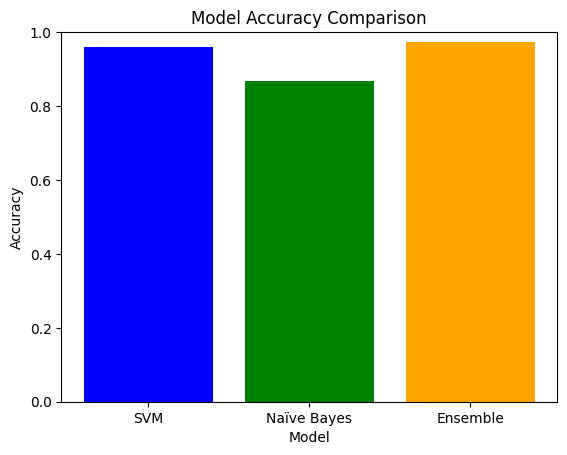

In [ ]:
plt.bar(['SVM', 'Naïve Bayes', 'Ensemble'], [svm_accuracy, nb_accuracy, ensemble_acc], color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [ ]:
if 'drug storage location' in df.columns:
    expired_drugs = df[df['expiry_category'] == 0][['drug id', 'expiry date', 'drug storage location']]
    for _, row in expired_drugs.iterrows():
        print(f"DRUG ID: {row['drug id']} | Expiry Date: {row['expiry date'].date()} | STORAGE LOCATION: {row['drug storage location']}")
        print("⚠️ The drug is expired! Immediate damage control is required.")
else:
    expired_drugs = df[df['expiry_category'] == 0][['drug id', 'expiry date']]
    for _, row in expired_drugs.iterrows():
        print(f"DRUG ID: {row['drug id']} | Expiry Date: {row['expiry date'].date()}")
        print("⚠️ The drug is expired! Immediate damage control is required.")

DRUG ID: 1009AA | Expiry Date: 2010-02-05 | STORAGE LOCATION: JAI BALAJI DISTRIBUTORS, NEW MARKET SHOP NO.**, GOLDEN HEIGHTS BUILDING,CHATRIBARI ROAD, KAMRUP, GUWAHATI  , Guwahati, Assam, 781001
⚠️ The drug is expired! Immediate damage control is required.
DRUG ID: 1077CA | Expiry Date: 2010-02-12 | STORAGE LOCATION: SUNDRAM FASTENERS LIMITED B ** SIPCOT INDUSTRIAL COMPLEX GUMMIDIPOONDI  , Gummudipoondi, Tamil Nadu, 601201
⚠️ The drug is expired! Immediate damage control is required.
DRUG ID: 1083AA | Expiry Date: 2010-02-19 | STORAGE LOCATION: Bakul-*, Shardashish Township, Torrent Power Limited, Off NH*, Kamrej, Surat,Gay pagla  , Kim, Gujarat, 394155
⚠️ The drug is expired! Immediate damage control is required.
DRUG ID: 1116CA | Expiry Date: 2010-02-26 | STORAGE LOCATION: Sonkar Bhawan, Near Ashok Kirana Store, Infront of Mohan aata chakki, Lakkhe nagar  , Raipur, Chhattisgarh, 492001
⚠️ The drug is expired! Immediate damage control is required.
DRUG ID: 1126CA | Expiry Date: 2010-0